O notebook a seguir é o projeto de MLP da cadeira de Sistemas Inteligentes. Para sua execução, irei usar a biblioteca MLP do SKLearn, e farei uma análise preliminar dos dados visando criar o melhor modelo possível.

# O dataset

Será usado um dataset de conjunto de sintomas de lombalgia, disponibilizado no Kaggle. Vou começar importando o dataset e vendo algumas propriedades:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

In [4]:
df = pd.read_csv('Dataset_spine.csv')

In [5]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


Analisando a coluna 13, para verificar se há alguma necessidade de mantê-la ou podemos dropar:

In [6]:
df['Unnamed: 13'].value_counts()

 Attribute8= Direct_tilt(numeric)                     1
Attribute class {Abnormal, Normal}                    1
Attribute5 = pelvic_radius (numeric)                  1
Attribute3 = lumbar_lordosis_angle (numeric)          1
 Attribute12= scoliosis_slope(numeric)                1
Prediction is done by using binary classification.    1
Attribute4 = sacral_slope (numeric)                   1
 Attribute11=sacrum_angle(numeric)                    1
 Attribute7= pelvic_slope(numeric)                    1
 Attribute10= cervical_tilt(numeric)                  1
 Attribute9= thoracic_slope(numeric)                  1
Attribute6 = degree_spondylolisthesis (numeric)       1
Attribute2 = pelvic_tilt (numeric)                    1
Attribute1  = pelvic_incidence  (numeric)             1
Name: Unnamed: 13, dtype: int64

In [12]:
df['Unnamed: 13'].isna().value_counts()

True     296
False     14
Name: Unnamed: 13, dtype: int64

In [11]:
list(df['Unnamed: 13'].isna().value_counts())[0]/len(df)

0.9548387096774194

A coluna conta com 95% de NAs, todos valores de texto livre, portanto, não há relevância preditiva para essa coluna e dessa forma ela será retirada do dataset:

In [15]:
df.drop(['Unnamed: 13'], axis=1, inplace=True)

Agora vou analisar os tipos dos dados e em seguida, fazer as modificações necessárias para deixar tudo númerico em função do modelo de previsão:

In [17]:
df.dtypes

Col1         float64
Col2         float64
Col3         float64
Col4         float64
Col5         float64
Col6         float64
Col7         float64
Col8         float64
Col9         float64
Col10        float64
Col11        float64
Col12        float64
Class_att     object
dtype: object

In [19]:
df.Class_att.value_counts()

Abnormal    210
Normal      100
Name: Class_att, dtype: int64

É necessário mudar apenas o tipo de dado da coluna Class_att, que é o target:

In [22]:
df.Class_att = df.Class_att.replace({'Abnormal': 0, 'Normal': 1})

In [23]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,0
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,0
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,0
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,0
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,0


Também foi mostrado a diferença entre casos anormais e normais que ocorreram no dataset. Não há um grande desbalanceamento:

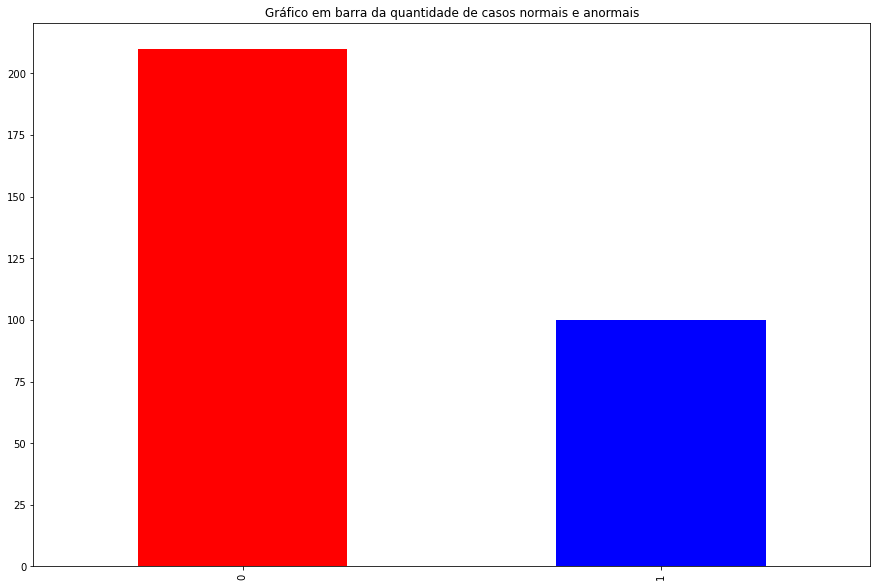

In [35]:
plt.figure(figsize=(15,10))
plt.title('Gráfico em barra da quantidade de casos normais e anormais')
df.Class_att.value_counts().plot(kind='bar', color=list('rb'))
plt.show()

Agora farei uma análise de correlação, começando pelo scatterplot das features:

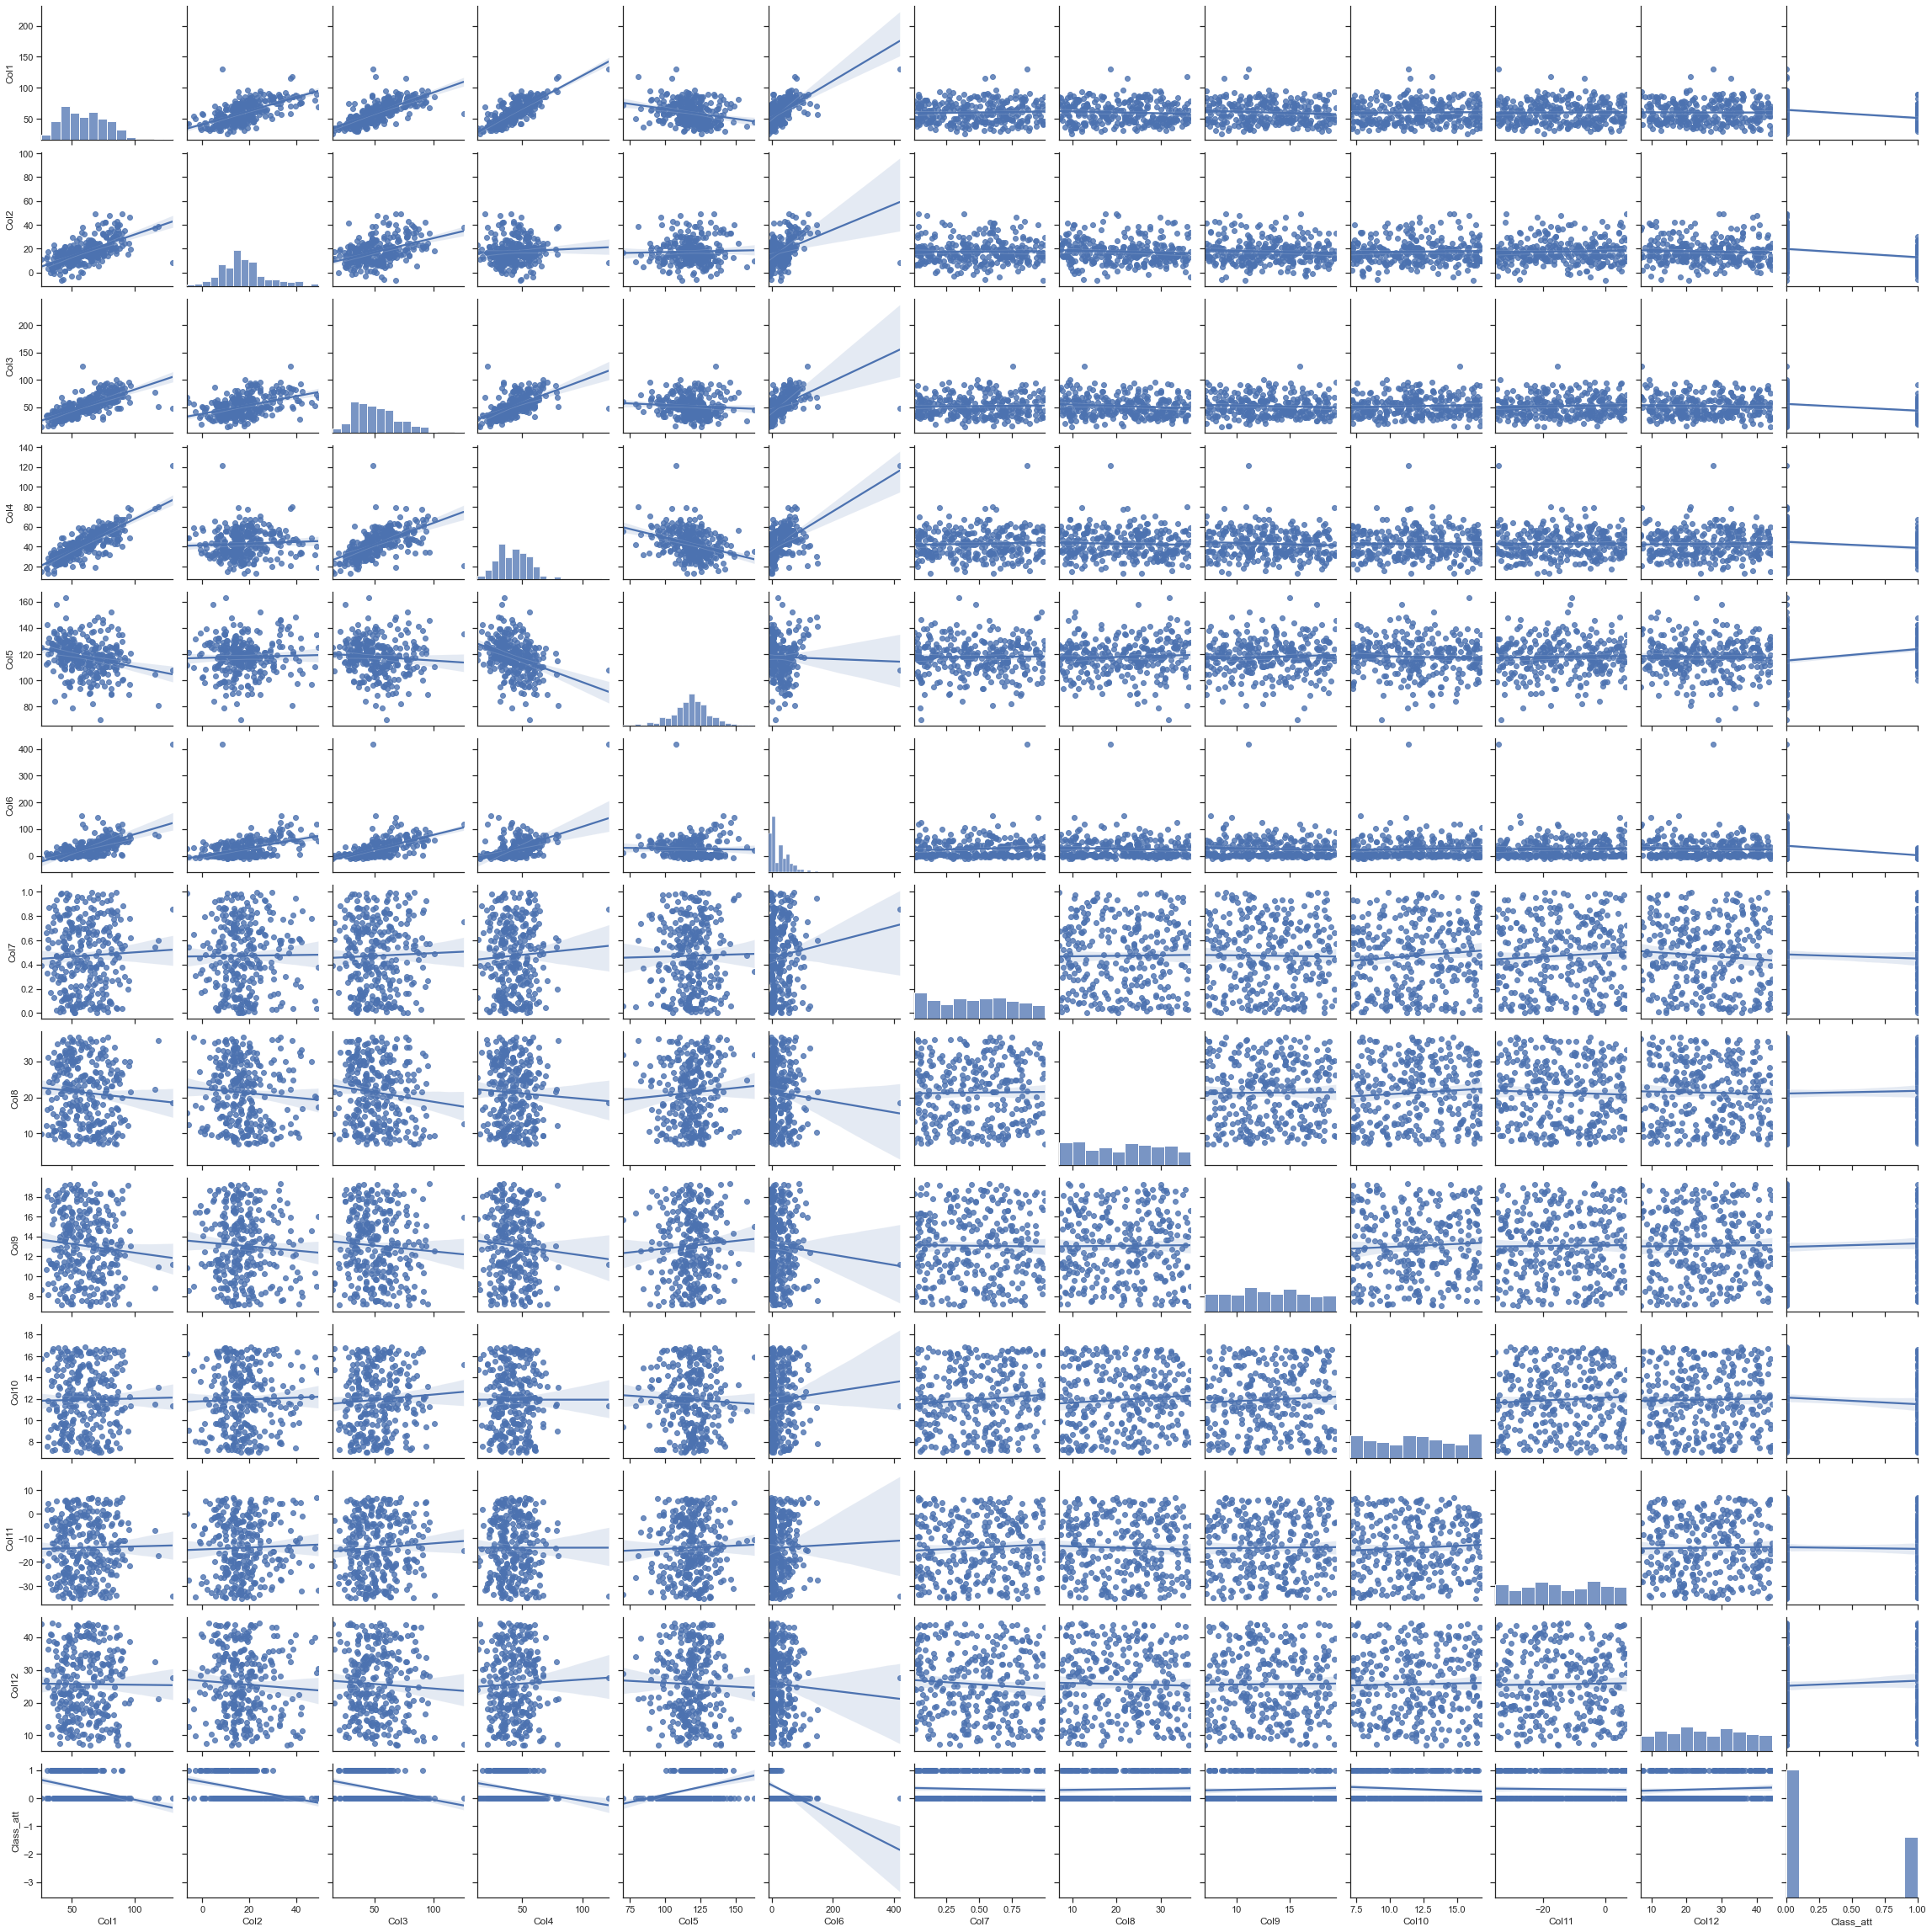

In [37]:
sns.set(style='ticks', color_codes=True)
sns.pairplot(df,kind='reg')
plt.show()

O gráfico acima dá um panorama geral da correlação, mas ela pode ser vista melhor com uma matriz de correlação:

In [38]:
cols = df.columns.values

corr = df.corr(method='pearson')
corr

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
Col1,1.000000,0.629199,0.717282,0.814960,-0.247467,0.638743,0.043290,-0.078411,-0.089740,0.016750,0.019240,-0.007251,-0.353336
Col2,0.629199,1.000000,0.432764,0.062345,0.032668,0.397862,0.008852,-0.072119,-0.063394,0.028931,0.032859,-0.056550,-0.326063
Col3,0.717282,0.432764,1.000000,0.598387,-0.080344,0.533667,0.029486,-0.112939,-0.063582,0.063875,0.057199,-0.049054,-0.312484
Col4,0.814960,0.062345,0.598387,1.000000,-0.342128,0.523557,0.048988,-0.046914,-0.067968,-0.000063,0.000207,0.032853,-0.210602
Col5,-0.247467,0.032668,-0.080344,-0.342128,1.000000,-0.026065,0.015767,0.063433,0.060477,-0.039800,0.029738,-0.030145,0.309857
Col6,0.638743,0.397862,0.533667,0.523557,-0.026065,1.000000,0.085925,-0.063812,-0.057286,0.056576,0.023021,-0.041023,-0.443687
Col7,0.043290,0.008852,0.029486,0.048988,0.015767,0.085925,1.000000,0.012694,-0.011770,0.088017,0.060743,-0.073893,-0.055865
Col8,-0.078411,-0.072119,-0.112939,-0.046914,0.063433,-0.063812,0.012694,1.000000,0.009887,0.072738,-0.037428,-0.024021,0.039591
Col9,-0.089740,-0.063394,-0.063582,-0.067968,0.060477,-0.057286,-0.011770,0.009887,1.000000,0.052451,0.011354,0.009541,0.049354
Col10,0.016750,0.028931,0.063875,-0.000063,-0.039800,0.056576,0.088017,0.072738,0.052451,1.000000,0.057451,0.021243,-0.100044


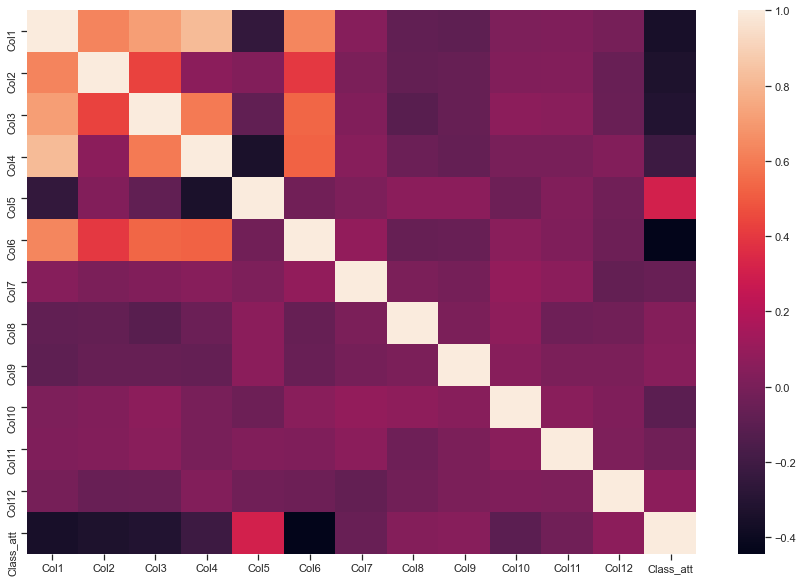

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

A coluna target tem correlação próxima a zero com quase todas as features, o que mostra que será difícil conseguir um modelo que traga uma boa previsão.

# O modelo

Será feito um MLP usando a biblioteca SKLearn, também farei variação de parâmetros e o scale do dataset.

In [43]:
X = df[df.columns[0:-1]]
y = df[['Class_att']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [45]:
scaler = preprocessing.StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [46]:
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_std, y_train)

/home/sergio/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(random_state=42)

In [47]:
print('Train score: {:.3f}'.format(mlp.score(X_train_std, y_train)))
print('Test score: {:.3f}'.format(mlp.score(X_test_std, y_test)))

Train score: 0.927
Test score: 0.795


Agora vou fazer o teste desse mesmo modelo, porém com grid search e cross-validation:

In [51]:
from sklearn.model_selection import GridSearchCV

In [53]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
}

clf = GridSearchCV(mlp, params, n_jobs=-1, cv=3)
clf.fit(X_train_std, y_train)

/home/sergio/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)]})

In [60]:
print('Train score: {:.3f}'.format(clf.score(X_train_std, y_train)))
print('Test score: {:.3f}'.format(clf.score(X_test_std, y_test)))

Train score: 0.879
Test score: 0.821


O modelo melhorou bastante após o grid search, tendo o score de teste aumentado e o de treino mais próximo dele, o que indica que não há overfit. Um gráfico interessante do mlp é analisar a participação de cada uma das features usando o coefs_ do sklearn. 

In [62]:
clf.best_params_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}

In [64]:
mlp = MLPClassifier(activation='tanh', alpha= 0.0001, hidden_layer_sizes= (100,), random_state=42)
mlp.fit(X_train_std, y_train)

/home/sergio/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/sergio/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', random_state=42)

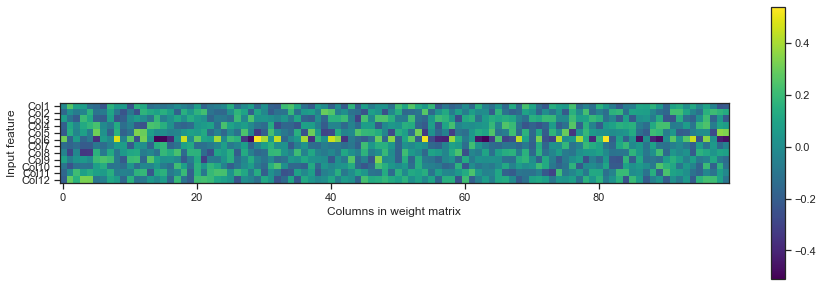

In [70]:
plt.figure(figsize=(15, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(X.columns)), X.columns)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()